# Application for the More Electric Aircraft (MEA) conference

# TODO

## Load and process

In [1]:
%matplotlib widget
import time
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from aeromaps.core.process import create_process
from aeromaps.core.models import models_complex
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
    SubCategory,
    SubcategoryParameters
)

In [2]:
process = create_process(
    models=models_complex,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

In [3]:
# Change end year
process.parameters.end_year = 2060
process.setup(add_examples_aircraft_and_subcategory=False)

## Set up variables

### Aviation scenario

In [4]:
# Paper settings

## Scenario settings
## Be careful: for all the scenarios, you have to specify manually the aircraft caracteristics (market share, performance, EIS...)
## Except for the mix scenario (4), you also have to specify manually the type of fuel used (ELECTRIC, HYBRID_ELECTRIC, HYDROGEN)
## For HYBRID_ELECTRIC architectures, you have to add an "hybridization_factor"
## Here, scenario (3) for the reference values is taken as an example
## Note that NOx, soot, DOC and cruise altitute are not considered here (random values)
SCENARIO = "Others"  # Choose between "Others" and "Mix"

## Settings for sensitivity analyses
DROP_IN_FUEL = "Kerosene"  # Choose between "Kerosene" and "ReFuelEU"
ELECTRICITY = "Dedicated"  # Choose between "Dedicated", "Current" and "Transition"

In [5]:
# Aircraft fleet for the other scenarios

if SCENARIO == "Others":

    ## Initialization
    fleet = process.fleet

    ## Subcat
    total_value = 33
    if total_value<=25:
        total_value_short = total_value/25*100
        total_value_medium = 0
    if total_value>25 and total_value<25+35:
        total_value_short = 100
        total_value_medium = (total_value-25)/35*100
        
    fleet.categories["Short Range"].subcategories[0].parameters.share = 100 - total_value_short
    sr_subcat = SubCategory("SR - New", parameters=SubcategoryParameters(share=total_value_short))
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    fleet.categories["Medium Range"].subcategories[0].parameters.share = 100 - total_value_medium
    mr_subcat = SubCategory("MR - New", parameters=SubcategoryParameters(share=total_value_medium))
    fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)

    ## Basic Short Range
    short_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=-75.0,
        soot_evolution=-100.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft = Aircraft(
        "New Short-range Aircraft - Conventional",
        parameters=short_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)


    ## New Short Range
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - New",
        parameters=short_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)


    ## Medium Range
    medium_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft = Aircraft(
        "New Medium-range Aircraft", parameters=medium_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

    ## New Medium Range
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - New",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Medium Range"].subcategories[1].add_aircraft(aircraft=medium_range_aircraft_new)


    ## Long Range
    long_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.,
    )
    long_range_aircraft = Aircraft(
        "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


    ## Fleet renewal
    fleet.categories["Short Range"].parameters.life = 20
    fleet.categories["Medium Range"].parameters.life = 20
    fleet.categories["Long Range"].parameters.life = 20

In [6]:
# Aircraft fleet for mix scenario

if SCENARIO == "Mix":
    ## Initialization
    fleet = process.fleet

    ## Subcat
    total_value = 47
    if total_value<=25:
        total_value_short = total_value/25*100
        total_value_medium = 0
    if total_value>25 and total_value<25+35:
        total_value_short = 100
        total_value_medium = (total_value-25)/35*100

    share_elec = 7 / 25 * 100
    share_hydrogen_sr = (25 - 7) / 25 * 100
    share_hydrogen_mr = (33 - 25) / 25 * 100

    fleet.categories["Short Range"].subcategories[0].parameters.share = 0
    sr_subcat = SubCategory("SR - Electric", parameters=SubcategoryParameters(share=share_elec))
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    sr_subcat = SubCategory("SR - Hydrogen/HE", parameters=SubcategoryParameters(share=share_hydrogen_sr))
    fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    sr_subcat = SubCategory("SR - Hybrid-lectric", parameters=SubcategoryParameters(share=100))
    # fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
    ## Subcat
    fleet.categories["Medium Range"].subcategories[0].parameters.share = 100 - share_hydrogen_mr
    mr_subcat = SubCategory("MR - Hydrogen/HE", parameters=SubcategoryParameters(share=share_hydrogen_mr))
    fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)
    mr_subcat = SubCategory("MR - Hybrid-electric", parameters=SubcategoryParameters(share=total_value_medium/2))
    # fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)

    ## Basic Short Range
    short_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=-75.0,
        soot_evolution=-100.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft = Aircraft(
        "New Short-range Aircraft - Conventional",
        parameters=short_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)


    ## New Short Range - Electric
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2040,
        consumption_evolution=50.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Electric",
        parameters=short_range_aircraft_new_params,
        energy_type="ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)


    ## New Short Range - Hybrid-electric
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Hybrid-electric",
        parameters=short_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )
    fleet.categories["Short Range"].subcategories[2].add_aircraft(aircraft=short_range_aircraft_new)

    ## New Short Range - Hydrogen
    short_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=5.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    short_range_aircraft_new = Aircraft(
        "New Short-range Aircraft - Hydrogen",
        parameters=short_range_aircraft_new_params,
        energy_type="HYDROGEN",
    )
    fleet.categories["Short Range"].subcategories[2].add_aircraft(aircraft=short_range_aircraft_new)



    ## Medium Range
    medium_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft = Aircraft(
        "New Medium-range Aircraft", parameters=medium_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

    ## New Medium Range - Electric
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2040,
        consumption_evolution=50.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - Electric",
        parameters=medium_range_aircraft_new_params,
        energy_type="ELECTRIC",
    )
    # fleet.categories["Medium Range"].subcategories[1].add_aircraft(aircraft=medium_range_aircraft_new)

    ## New Medium Range - Hybrid-electric
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2030,
        consumption_evolution=-10.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.4,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - Hybrid-electric",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYBRID_ELECTRIC",
    )

    fleet.categories["Medium Range"].subcategories[1].add_aircraft(aircraft=medium_range_aircraft_new)

    ## New Medium Range - Hydrogen
    medium_range_aircraft_new_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=5.0,
        nox_evolution=-50.0,
        soot_evolution=-50.0,
        doc_non_energy_evolution=10.0,
        cruise_altitude=12000.0,
    )
    medium_range_aircraft_new = Aircraft(
        "New Medium-range Aircraft - Hydrogen",
        parameters=medium_range_aircraft_new_params,
        energy_type="HYDROGEN",
    )
    fleet.categories["Medium Range"].subcategories[1].add_aircraft(aircraft=medium_range_aircraft_new)


    ## Long Range
    long_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        hybridization_factor=0.,
    )
    long_range_aircraft = Aircraft(
        "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


    ## Fleet renewal
    fleet.categories["Short Range"].parameters.life = 20
    fleet.categories["Medium Range"].parameters.life = 20
    fleet.categories["Long Range"].parameters.life = 20

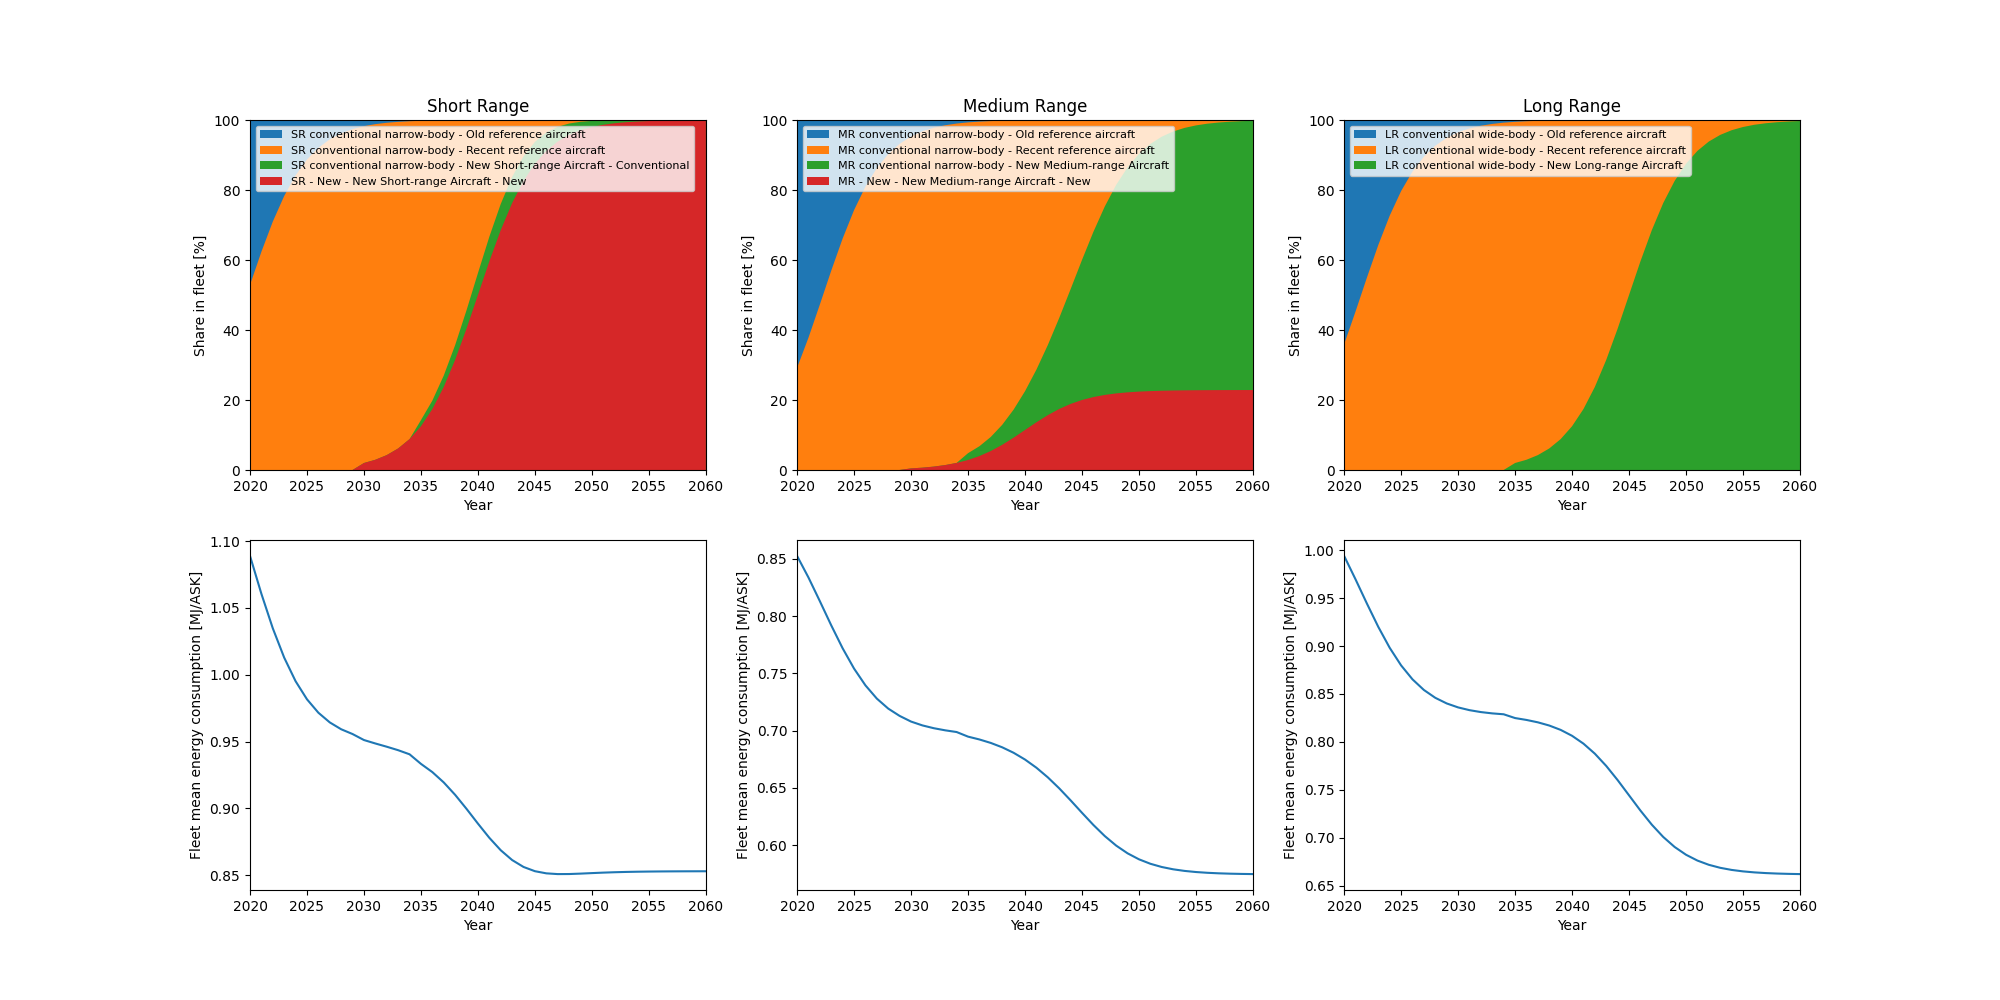

In [7]:
fleet_model = process.fleet_model
fleet_model.compute()
fleet_model.plot()

In [8]:
# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
if DROP_IN_FUEL == "Kerosene":
    process.parameters.biofuel_share_reference_years = []
    process.parameters.biofuel_share_reference_years_values = [0.0]
    process.parameters.electrofuel_share_reference_years = []
    process.parameters.electrofuel_share_reference_years_values = [0.0]
elif DROP_IN_FUEL == "ReFuelEU":
    process.parameters.biofuel_share_reference_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.biofuel_share_reference_years_values = [0.0, 4.8, 24.0, 35.0, 40.0]
    process.parameters.electrofuel_share_reference_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.electrofuel_share_reference_years_values = [0.0, 1.2, 10.0, 35.0, 60.0]

In [9]:
# Various environmental settings

## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
## Assumption of a current use of HEFA FOG and an equal distribution from 2030 according to biomass resources distribution
process.parameters.biofuel_hefa_fog_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_hefa_fog_share_reference_years_values = [100, 0.7, 0.7]
process.parameters.biofuel_hefa_others_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_hefa_others_share_reference_years_values = [0.0, 3.8, 3.8]
process.parameters.biofuel_ft_others_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_ft_others_share_reference_years_values = [0.0, 76.3, 76.3]
process.parameters.biofuel_ft_msw_share_reference_years = [2020, 2030, 2060]
process.parameters.biofuel_ft_msw_share_reference_years_values = [0.0, 7.4, 7.4]

## Emission factors for electricity (2019 value: 429 gCO2/kWh)
if ELECTRICITY == "Dedicated":
    process.parameters.electricity_emission_factor_reference_years = []
    process.parameters.electricity_emission_factor_reference_years_values = [10.0]
elif ELECTRICITY == "Current":
    process.parameters.electricity_emission_factor_reference_years = []
    process.parameters.electricity_emission_factor_reference_years_values = [429.0]
elif ELECTRICITY == "Transition":
    process.parameters.electricity_emission_factor_reference_years = [2020, 2060]
    process.parameters.electricity_emission_factor_reference_years_values = [429.0, 0.0]

## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
## Assumption of a dedicated use of electrolysis pathway here
process.parameters.hydrogen_electrolysis_share_reference_years = []
process.parameters.hydrogen_electrolysis_share_reference_years_values = [100]
process.parameters.hydrogen_gas_ccs_share_reference_years = []
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0]
process.parameters.hydrogen_coal_ccs_share_reference_years = []
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0]
process.parameters.hydrogen_gas_share_reference_years = []
process.parameters.hydrogen_gas_share_reference_years_values = [0]

In [10]:
# Other settings

## Air traffic evolution - Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [3.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [3.0]

## Aircraft fleet and operation evolution - Aircraft load factor
process.parameters.load_factor_end_year = 89  # 2019 value: 82.399312

# Aircraft fleet and operation evolution - Operations
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## Compute

In [11]:
process.compute()

C:\Users\t.planes\PycharmProjects\AeroMAPS\aeromaps\models\base.py:73: UserWarning: Warning Message - Model name: coal_cost - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
C:\Users\t.planes\PycharmProjects\AeroMAPS\aeromaps\models\base.py:73: UserWarning: Warning Message - Model name: coal_cost - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
C:\Users\t.planes\PycharmProjects\AeroMAPS\aeromaps\models\base.py:73: UserWarning: Warning Message - Model name: electrolyser_capex - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last referenc

## Results

The following results are those obtained for the scenario set previously.

In [12]:
print(
    "CO2 emissions in 2050:",
    round(process.data["climate_outputs"]["co2_emissions"][2050], 0),
    "MtCO2",
)
print(
    "Cumulative CO2 emissions between 2020 and 2050:",
    round(process.data["vector_outputs"]["cumulative_co2_emissions"][2050], 1),
    "GtCO2",
)
print(
    "Energy consumption in 2050:",
    round(process.data["vector_outputs"]["energy_consumption"][2050]/10**12, 1),
    "EJ",
)
print(
    "CO2 emissions in 2060:",
    round(process.data["climate_outputs"]["co2_emissions"][2060], 0),
    "MtCO2",
)

CO2 emissions in 2050: 1210.0 MtCO2
Cumulative CO2 emissions between 2020 and 2050: 32.4 GtCO2
Energy consumption in 2050: 16.1 EJ
CO2 emissions in 2060: 1579.0 MtCO2


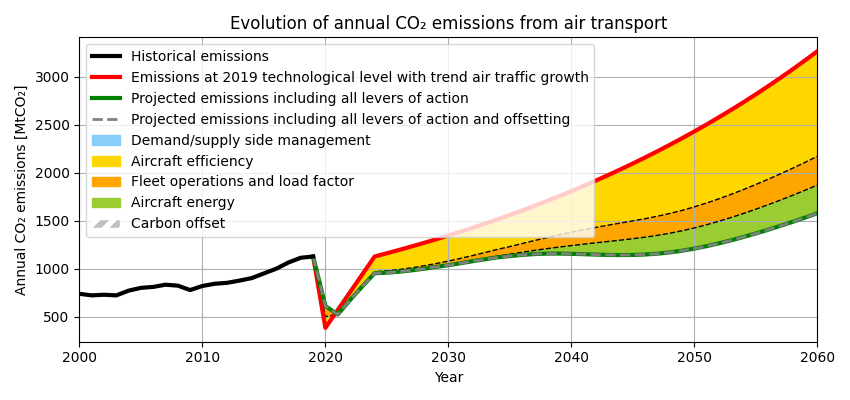

In [13]:
process.plot("air_transport_co2_emissions")

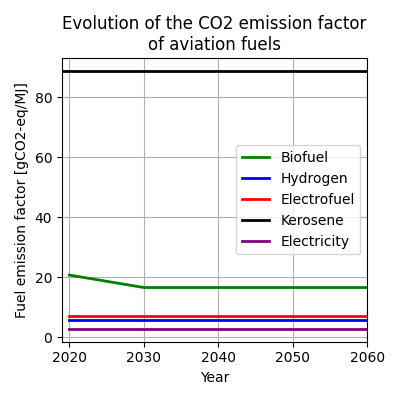

In [14]:
process.plot("emission_factor_per_fuel")

# All results

This part includes the main plots of the paper, summarizing the different scenarios and sensitivity analyses.

## Baseline scenarios

In [15]:
mea_data_df = read_csv("data/mea_data.csv", delimiter=";")
mea_data = mea_data_df.values
mea_data_reference = mea_data[:, 1]
mea_data_electric = mea_data[:, 2]
mea_data_electric_low = mea_data[:, 3]
mea_data_electric_high = mea_data[:, 4]
mea_data_hybridelectric = mea_data[:, 5]
mea_data_hybridelectric_low = mea_data[:, 6]
mea_data_hybridelectric_high = mea_data[:, 7]
mea_data_hydrogen = mea_data[:, 8]
mea_data_hydrogen_low = mea_data[:, 9]
mea_data_hydrogen_high = mea_data[:, 10]
mea_data_mix = mea_data[:, 11]

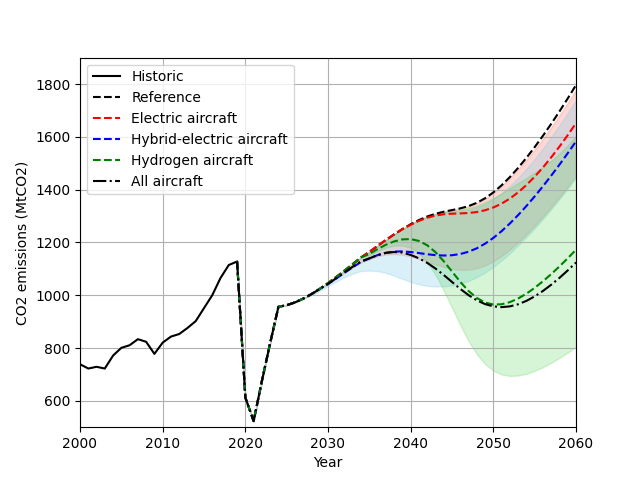

In [16]:
data_years_total = list(range(1940,2101))

fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000-1940:2000-1940+20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_reference[0:42],
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electric[0:42],
    color="red",
    label="Electric aircraft",
    linestyle="--",
)
ax.fill_between(process.data["years"]["prospective_years"],mea_data_electric_low[0:42], mea_data_electric_high[0:42], color='salmon', alpha=0.3)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hybridelectric[0:42],
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)
ax.fill_between(process.data["years"]["prospective_years"], mea_data_hybridelectric_low[0:42], mea_data_hybridelectric_high[0:42], color='skyblue', alpha=0.3)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hydrogen[0:42],
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)
ax.fill_between(process.data["years"]["prospective_years"], mea_data_hydrogen_low[0:42], mea_data_hydrogen_high[0:42], color='limegreen', alpha=0.2)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_mix[0:42],
    color="black",
    label="All aircraft",
    linestyle="-.",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(500, 1900)
plt.legend()
plt.show()

## Sensitivity to ReFuelEU

In [17]:
mea_data_refueleu_df = read_csv("data/mea_data_refueleu.csv", delimiter=";")
mea_data_refueleu = mea_data_refueleu_df.values
mea_data_refueleu_reference = mea_data_refueleu[:, 1]
mea_data_refueleu_electric = mea_data_refueleu[:, 2]
mea_data_refueleu_hybridelectric = mea_data_refueleu[:, 3]
mea_data_refueleu_hydrogen = mea_data_refueleu[:, 4]
mea_data_refueleu_mix = mea_data_refueleu[:, 5]

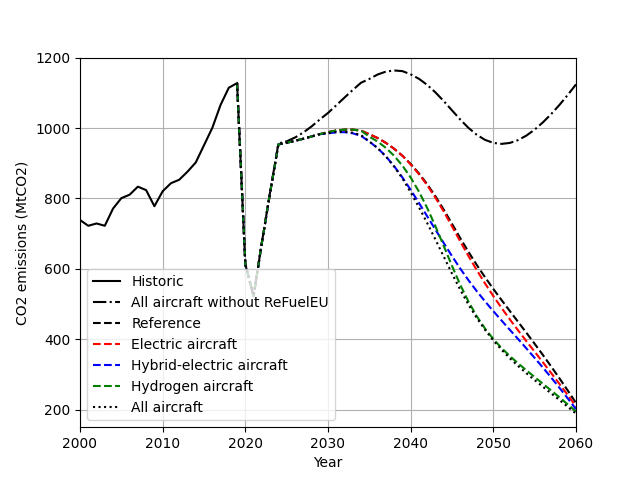

In [18]:
fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000-1940:2000-1940+20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_mix[0:42],
    color="black",
    label="All aircraft without ReFuelEU",
    linestyle="-.",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_reference,
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_electric,
    color="red",
    label="Electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hybridelectric,
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hydrogen,
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_mix,
    color="black",
    label="All aircraft",
    linestyle=":",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(150, 1200)
plt.legend()
plt.show()

## Sensitivity to electricity emission factor